In [3]:
import os
from pydicom import read_file,dcmread
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
%matplotlib inline
io.use_plugin("matplotlib")

/home/youngwon/.local/lib/python3.8/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.17.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/youngwon/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
data_root = '/mnt/NAS/youngwon/handle/data/SN00000130'
dcm_list = os.listdir(data_root)
dcm_list.sort()
ds = dcmread(os.path.join(data_root,dcm_list[0]))
slope,inter = ds.RescaleSlope,ds.RescaleIntercept
print(type(slope),type(inter))

<class 'pydicom.valuerep.DSfloat'> <class 'pydicom.valuerep.DSfloat'>


In [5]:
root = '/mnt/NAS/youngwon/handle/mask/SN00000130'
blend_list = [ os.path.join(root,path) for path in os.listdir('/mnt/NAS/youngwon/handle/mask/SN00000130')]
blend_list.sort()

In [6]:
root = '/mnt/NAS/youngwon/handle/data'
paths = os.listdir('/mnt/NAS/youngwon/handle/data')
paths.sort()
#130
dcm_list = [ os.path.join(root+'/'+paths[0] ,i) for i in os.listdir(root + '/' + paths[0])]
slices = [dcmread(os.path.join(paths[0],i)) for i in dcm_list]
slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))
image = np.stack([s.pixel_array for s in slices])
image = image.astype(np.int16)

In [7]:
def transform_to_hu(slices,image,axial):
    intercept = slices[axial].RescaleIntercept
    slope = slices[axial].RescaleSlope
    hu_image  = slope * image + intercept
    return hu_image

In [8]:
def normalize_image(image,center,width):
    '''
        window level tuning
    '''
    img_min = center-width// 2
    img_max = center+width// 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    window_image = (window_image -img_min) / width
    return window_image

In [9]:
axial = 0
image = transform_to_hu(slices=slices,image=image,axial=axial)
# plt.imshow(image[0],cmap='gray')
window_image = image.copy()
print(np.min(image),np.max(image))
min,max = -1250.0,250.0

-3054.0 2758.0


0.0 1.0


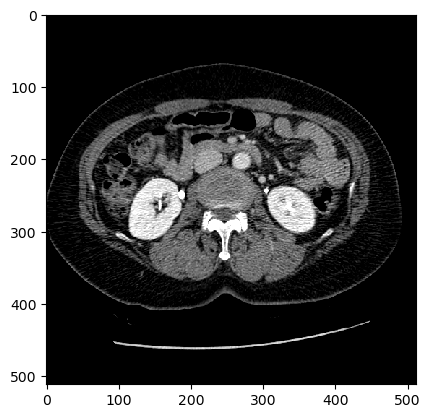

In [10]:
c = 100
w = 400
window_image = normalize_image(image,c,w)
print(np.min(window_image),np.max(window_image))
# window_image *= 2**8-1
# window_image = window_image.astype(np.uint8)
plt.imshow(window_image[axial],cmap='gray',clim=(0,1))
plt.show()

In [11]:
numbers = '125/126/127/130/131/132/133/134/136/137'
for i in numbers.split('/'):
    index = int(i)
    io.imsave(f'sample{index}.png',window_image[index-1])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

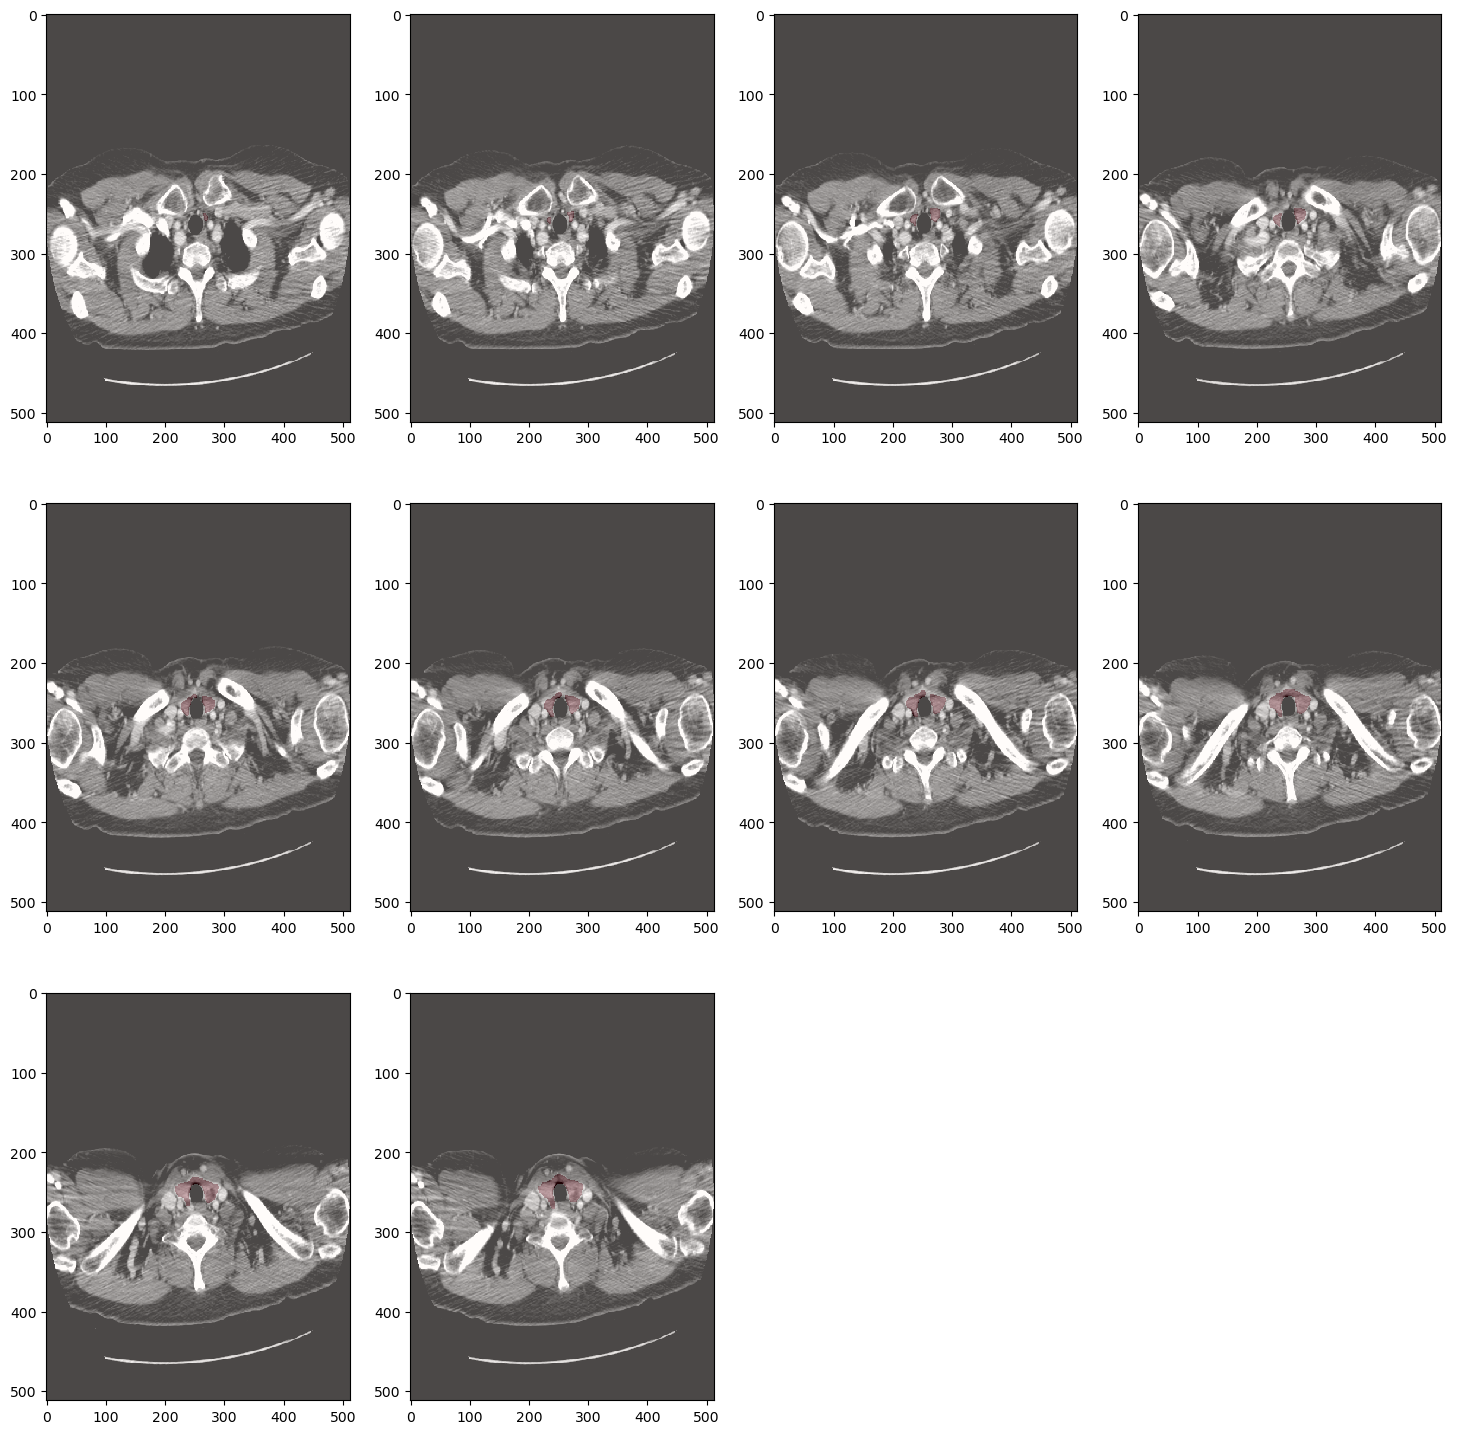

In [12]:
target_paths = [f'sample{path}.png' for path in numbers.split('/')]
mask_root = '/mnt/NAS/youngwon/handle/mask/SN00000130'
mask_paths = [os.path.join(mask_root, i) for i in os.listdir('/mnt/NAS/youngwon/handle/mask/SN00000130')]
mask_paths.sort()
output = []
masks, targets = [], []
alpha = 0.6
for i in range(len(numbers.split('/'))):
    target_path,mask_path = target_paths[i],mask_paths[i]
    target = Image.open(target_path)
    mask = Image.open(mask_path)
    out = Image.blend(mask,target,alpha=0.6)
    out = np.asarray(out)
    output.append(out) #지양하는 것이 좋음
    masks.append(np.asarray(mask))
    targets.append(np.asarray(target))
    
plt.figure(figsize=(18,18))
for i in range(len(output)):
    plt.subplot(3,4,i+1)
    # plt.imshow(output[i],cmap='bone')
    plt.imshow(targets[i], cmap='gray')
    # plt.imshow(np.where(masks[i]==1., 0.5, 0), cmap='inferno', alpha=.5,clim=(0,1))
    plt.imshow(masks[i], cmap='Reds',alpha=0.3)
    plt.axis('tight')
    


In [13]:
def getDirs(data_root='/mnt/NAS/youngwon/handle/data',mask_root='/mnt/NAS/youngwon/handle/mask'):
    data_dirs = [os.path.join(data_root,i) for i in sorted(os.listdir(data_root)) if 'DS_Store' not in i]
    mask_dirs = [os.path.join(mask_root,i) for i in sorted(os.listdir(mask_root)) if 'DS_Store' not in i]
    return (data_dirs,mask_dirs)

In [14]:
def getDcmList(data_path,mask_path):
    data_dcm_paths = [os.path.join(data_path,i) for i in sorted(os.listdir(data_path))]
    mask_png_paths = [os.path.join(mask_path,i) for i in sorted(os.listdir(mask_path))]
    return (data_dcm_paths,mask_png_paths)
    

In [15]:
def getDcmImage(dcm_list,center:int=100,width:int=400):
    slices = [dcmread(i) for i in dcm_list]
    slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image = transform_to_hu(slices=slices,image=image,axial=axial)
    window_image = normalize_image(image,center,width)
    return window_image

In [16]:
def getNumbers(mask_png_paths):
    numbers = [int(i.split('_')[1][:-4]) for i in mask_png_paths]
    return numbers

In [21]:
def showImage(window,numbers,mask_paths,patient_name,alpha:float=0.3):
    
    os.makedirs('/mnt/NAS/youngwon/samples/{0}'.format(patient_name),exist_ok=True)
    
    masks, targets = [], []
    index=0
    for i in range(window.shape[0]):
        target = Image.fromarray(window[i])
        if i+1 in numbers:
            mask = Image.open(mask_paths[index])
            masks.append(np.asarray(mask))
            index+=1
        targets.append(np.asarray(target))
    
    index = 0    
    for i in range(window.shape[0]):
        plt.figure(figsize=(36,18))
        if i+1 in numbers:
            plt.subplot(1,2,1)
            plt.imshow(targets[i], cmap='gray')
            plt.subplot(1,2,2)
            plt.imshow(targets[i],cmap='gray')
            plt.imshow(masks[index], cmap='Reds',alpha=alpha)
            plt.axis('tight')
            index+=1
        else:
            plt.subplot(1,1,1)
            plt.imshow(targets[i],cmap='gray')
            plt.axis('tight')
        plt.savefig('/mnt/NAS/youngwon/samples/{0}/{1:03d}.png'.format(patient_name,i))

In [22]:
a,b = getDirs()
n = len(a)
for i in range(n):
    c,d = getDcmList(a[i],b[i])
    window = getDcmImage(c)
    numbers = getNumbers(d)
    patient = d[0].split('/')[-2]
    showImage(window,numbers,d,patient)
    

/tmp/ipykernel_1898925/3562965993.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,1,1)
